In [2]:
!ls ../data/

breast-cancer-wisconsin.data.csv  names_test.csv.gz   raw
diabetes.csv.gz			  names_train.csv.gz  shakespeare.txt.gz


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.externals import joblib
from collections import Counter

import pathlib as plib
import pdb
import types

In [4]:
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__

In [5]:
#Globals
ROOT = plib.Path("/root/fastai/Playground/LUNA")
nRuns = 5 #number of test runs per unit
RSEED = 11;

In [6]:
cd $ROOT

/root/fastai/Playground/LUNA


In [7]:
pwd

'/root/fastai/Playground/LUNA'

In [8]:
# To list all packages imported
list(imports())

['builtins',
 'builtins',
 'torch',
 'torch.nn',
 'torch.optim',
 'torch.nn.functional',
 'numpy',
 'matplotlib.pyplot',
 'pandas',
 'sklearn.externals.joblib',
 'pathlib',
 'pdb',
 'types']

### Simple Data load

In [110]:
x_data = torch.Tensor([[1,2,3,4]]).view(4,1)
y_data = torch.Tensor([0,0,1,1]).view(4,1)

In [111]:
print(x_data, '\n', y_data)

tensor([[ 1.],
        [ 2.],
        [ 3.],
        [ 4.]]) 
 tensor([[ 0.],
        [ 0.],
        [ 1.],
        [ 1.]])


Load diabetes dataset

In [180]:
fpath_diabetes = '../PytorchStarter/data/diabetes.csv.gz'
xy = np.loadtxt(fpath_diabetes, delimiter=',', dtype=np.float32)
print(xy.shape); print(xy)

(759, 9)
[[-0.294118   0.487437   0.180328  ... -0.53117   -0.0333333  0.       ]
 [-0.882353  -0.145729   0.0819672 ... -0.766866  -0.666667   1.       ]
 [-0.0588235  0.839196   0.0491803 ... -0.492741  -0.633333   0.       ]
 ...
 [-0.411765   0.21608    0.180328  ... -0.857387  -0.7        1.       ]
 [-0.882353   0.266332  -0.0163934 ... -0.768574  -0.133333   0.       ]
 [-0.882353  -0.0653266  0.147541  ... -0.797609  -0.933333   1.       ]]


In [113]:
X = xy[:,:-1]; print(X.shape)
y = xy[:,-1]; print(y.shape)

(759, 8)
(759,)


In [114]:
X = torch.from_numpy(X) #share the same memory 
y = torch.from_numpy(y)

Train and test set


### Custom data loader [OLD]

In [182]:
# OLD
# class DiabetesDataset(Dataset):
#     def __init__(self, ids):
#         # Ideally we wouldn't load all data here.
#         # Rather, read each file when __getitem__ is called
#         xy = np.loadtxt('../data/diabetes.csv.gz', delimiter=',', dtype=np.float32)
#         self.x_data = xy[:,:-1]
#         self.y_data = xy[:, -1]
        
#         self.ids = ids
#         self.len = len(ids)

        
#     def __getitem__(self, idx):
#         "Returns a sample in the format of [x_data[ID], y_data[ID]]"
# #         print("idx: ", idx)
#         ID = self.ids[idx]
#         return self.x_data[ID,:], self.y_data[ID]
    
#     def __len__(self):
#         return self.len

### Load LunaCsvDataset [NEW]

Note: Refer to repair_analysis.ipynb for filtering out fraud datasets and relabelling the rest of data   
label_dict = {'KGB':0, 'Cracked':1, 'Repaired':2, 'NoPSA':0, }

In [205]:
# import sys,os
# sys.path.append(os.path.abspath("../Scripts/"))
# from data_helpers import LunaCsvDataset, LunaPickleDataset

In [9]:
class LunaCsvDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        #todo: add ids, modify __len__
        """
        - csv_file (string): path to the csv file
        - root_dir (string or pathlib.Path object): directory with all the images
        - transform (callable, optional): optional transform to be applied to a sample
        """
        all_data = pd.read_csv(csv_file, header=0, index_col=0)
        # Filter out fruad datapoints
        is_not_fraud = [False if 'Fraud' in all_data.state[i] else True for i in range(len(all_data))]
        all_data = all_data[is_not_fraud]        
        self.data = np.array(all_data.drop('state', axis=1)) 
        self.target = np.array(all_data['state'])
        self.root_dir = root_dir
        self.transform = transform
    #todo
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        "returns a sample of format (feature 1,...,featureD, class)"
        return (self.data[idx, :], self.target[idx])
    
    #todo
    def set_label_dict(self, new_dict):
        self.label_dict = new_dict

class LunaPickleDataset(Dataset):
    def __init__(self, pk_file, ids, root_dir, transform=None):
        """
        - pk_file (string): path to the pickled file
        - root_dir (string): directory with all the images
        - transform (callable, optional): optional transform to be applied to a sample
        """
        all_data = joblib.load(pk_file) 
#         is_not_fraud = [False if 'Fraud' in all_data.state[i] else True for i in range(len(all_data))]
#         all_data = all_data[is_not_fraud]
        self.data = np.array(all_data.drop(['sn', 'state'], axis=1),
                            dtype=np.float32) # for compatibility with torch.FloatTensor
#         self.label_dict = {'KGB':0, 'Cracked':1, 'Repaired':2, 'NoPSA':0, }
        self.targets = np.array(all_data.state, 
                               dtype=np.int)
    
        self.ids = ids
        self.len = len(self.ids)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        "returns a sample of format [ [feature 1,...,featureD], target, idx]"
        ID = self.ids[idx]
        sample = (self.data[ID, :], self.targets[ID], idx)
        if self.transform:
            sample = self.transform(sample)
        return sample

#### Test LunaDataset objects

In [208]:
fpath_luna = ROOT/'Data/DataMatrix/D_rr_rrr.csv'
d = pd.read_csv(fpath_luna, header=0, index_col=0);
d.columns
dataset = LunaCsvDataset(fpath_luna ,root_dir=ROOT)
print(dataset.data.shape, dataset.target.shape)
print('labels: ', np.unique(dataset.target))
print('11th sample: ', dataset[10])

Index(['0_rr', '1_rr', '2_rr', '3_rr', '4_rr', '5_rr', '6_rr', '7_rr', '8_rr',
       '9_rr', '10_rr', '11_rr', '12_rr', '13_rr', '14_rr', '15_rr', '16_rr',
       '17_rr', '18_rr', '19_rr', '20_rr', '21_rr', '22_rr', '23_rr', '24_rr',
       '25_rr', '26_rr', '27_rr', '28_rr', '29_rr', '30_rr', '31_rr', '32_rr',
       '33_rr', '34_rr', '35_rr', '36_rr', '37_rr', '38_rr', '39_rr', '40_rr',
       '41_rr', '42_rr', '43_rr', '44_rr', '45_rr', '46_rr', '47_rr', '0_rrr',
       '1_rrr', '2_rrr', '3_rrr', '4_rrr', '5_rrr', '6_rrr', '7_rrr', '8_rrr',
       '9_rrr', '10_rrr', '11_rrr', '12_rrr', '13_rrr', '14_rrr', '15_rrr',
       '16_rrr', '17_rrr', '18_rrr', '19_rrr', '20_rrr', '21_rrr', '22_rrr',
       '23_rrr', '24_rrr', '25_rrr', '26_rrr', '27_rrr', '28_rrr', '29_rrr',
       '30_rrr', '31_rrr', '32_rrr', '33_rrr', '34_rrr', '35_rrr', '36_rrr',
       '37_rrr', '38_rrr', '39_rrr', '40_rrr', '41_rrr', '42_rrr', '43_rrr',
       '44_rrr', '45_rrr', '46_rrr', '47_rrr', 'sn', 'state'],
 

### Load Luna data without fraud units

In [410]:
# fpath = ROOT/'Data/DataMatrix/D_rr_rrr_noFraud.pkl' #0: KGB or NoPSA, 1: Cracked, 2: BadRepair
# fpath = ROOT/'Data/DataMatrix/D_rr_rrr_only_kgb_cracked.pkl' #0:KGB, 1:Cracked
fpath = ROOT/'Data/DataMatrix/D_rr_rrr_only_kgb_badrepair.pkl' #0:KGB, 1:BadRepair

In [435]:
d = joblib.load(ROOT/fpath)
dataset = LunaPickleDataset(fpath, range(len(d)), root_dir=ROOT) #load entire dataset
print("Loaded Luna data with ONLY kgb and badrepair info")
print("data and target sizes: ", dataset.data.shape, dataset.target.shape)
print("Labels: ", np.unique(dataset.target)) 

Loaded Luna data with ONLY kgb and badrepair info
data and target sizes:  (507, 96) (507,)
Labels:  [0 2]


### Normalize the kgb-badrepair data

Compute the mean and variance from all kgb samples

In [442]:
for name, g in d.groupby('state'):
    print(f"class {int(name)}: {g.state.count()}")

class 0: 372
class 2: 135


In [471]:
d_kgb = d[d.state==0].drop(['sn','state'], axis=1); print(d_kgb.shape)
mu_kgb = d_kgb.mean(axis=0); print(mu_kgb.shape); #mu_kgb
std_kgb = d_kgb.std(axis=0); print(std_kgb.shape)

(372, 96)
(96,)
(96,)


In [472]:
# normalizer = transforms.Normalize(mean=mu_kgb, std=std_kgb)
from sklearn.preprocessing import StandardScaler

In [478]:
scaler = StandardScaler()
scaler.fit(d_kgb)
#print(scaler.mean_, scaler.var_)

In [479]:
scaled_data = scaler.transform(d.drop(['sn', 'state'], axis=1))

In [487]:
scaled_d = d.copy()
scaled_d.iloc[:,:-2] = scaled_data

In [488]:
scaled_d

,0_rr,1_rr,2_rr,3_rr,4_rr,5_rr,6_rr,7_rr,8_rr,9_rr,...,40_rrr,41_rrr,42_rrr,43_rrr,44_rrr,45_rrr,46_rrr,47_rrr,sn,state
104,5.931533,2.102955,6.210149,3.117742,2.696490,2.425905,2.493749,1.779586,2.878011,2.857698,...,-0.093967,-0.102755,-0.343265,-0.138225,-0.132029,0.137913,-0.168386,-0.075813,FK3VL2VLJCL6,2.0
105,-0.810072,-0.453475,-0.411790,-0.121522,-0.390715,-0.645898,-0.573187,-0.586418,-0.699149,1.438080,...,-0.121667,-0.205135,-0.444325,-0.148888,-0.217568,-0.181909,-0.240998,-0.089408,C39VMC1YJCL7,2.0
106,5.444275,1.831775,7.111072,4.575378,4.089973,3.769078,4.501199,2.621409,5.369341,5.491001,...,-0.117539,-0.193247,-0.389859,-0.144120,-0.205769,-0.172912,-0.228944,-0.087976,G0NVN150JCLJ,2.0
107,-0.491840,-0.104167,-0.293582,-0.164649,-0.513360,-0.343525,-0.577840,-0.315793,-0.570568,-0.665754,...,-0.059889,0.885310,-0.372617,-0.135244,-0.185002,-0.075759,-0.164602,-0.085176,FK2VQ5TTJCL8,2.0
108,-0.988062,-0.476608,-0.885162,-0.691764,-0.696767,-0.932271,-1.221469,-0.901348,-1.056595,-1.127827,...,-0.105480,-0.143271,-0.383236,-0.137069,-0.178817,-0.163893,-0.212574,-0.085267,F17VK4C1JCL8,2.0
109,-1.217828,-0.554401,-0.886535,-0.625021,-0.843715,-1.192816,-1.354224,-1.058467,-1.140791,-1.135582,...,-0.103140,0.084072,-0.288756,-0.140267,-0.190331,-0.164269,-0.212860,-0.078226,DNPVLSKCJCL8,2.0
110,-0.982644,-0.516823,-0.772645,-0.546408,-0.700692,-0.991409,-1.133810,-0.879561,-0.986921,-0.922317,...,-0.059520,-0.178140,-0.386450,-0.137607,-0.192649,-0.155499,-0.129220,-0.086006,G6TVJ0XUJCLJ,2.0
111,0.859935,0.455642,3.388609,2.869466,1.137428,1.121021,0.868471,0.947952,0.779132,1.335907,...,-0.119711,-0.194094,-0.427129,-0.147372,-0.213068,-0.177680,-0.235176,-0.088869,F2MVP5CLJCLH,2.0
112,1.827368,0.417818,2.758361,2.153674,0.950922,1.534312,1.387566,1.130540,1.049769,1.658898,...,-0.097878,-0.191733,-0.376738,-0.136621,-0.156532,-0.170993,-0.141437,-0.088470,G6VVRG07JCLJ,2.0
113,-0.605124,-0.224952,0.100056,-0.119018,0.275660,-0.131941,0.264571,-0.167182,0.021776,0.698942,...,-0.120944,-0.197538,-0.402356,-0.147181,-0.213209,-0.178259,-0.215681,-0.085343,DNQVR0H7JCL9,2.0


In [491]:
joblib.dump(scaled_d, './Data/DataMatrix/D_rr_rrr_kgb_badrepair_scaled.pkl')

['./Data/DataMatrix/D_rr_rrr_kgb_badrepair_scaled.pkl']

### Load normalized kgb-repaired dataset

In [10]:
fpath = ROOT/'Data/DataMatrix/D_rr_rrr_kgb_badrepair_scaled_binary.pkl'
d = joblib.load(ROOT/fpath)
dataset = LunaPickleDataset(fpath, range(len(d)), root_dir=ROOT) #load entire dataset
print("Loaded Luna data with ONLY kgb and badrepair info")
print("data and target sizes: ", dataset.data.shape, dataset.targets.shape)
print("Labels: ", np.unique(dataset.targets)) #0: KGB or NoPSA, 1: BadRepair

Loaded Luna data with ONLY kgb and badrepair info
data and target sizes:  (507, 96) (507,)
Labels:  [0 1]


Check if really normalized

In [11]:
print("mean: ", d.iloc[:,:-2].mean(axis=0).mean())
print("std: ", d.iloc[:,:-2].std(axis=0).mean())

d

mean:  0.10144422734369374
std:  1.686360767111375


,0_rr,1_rr,2_rr,3_rr,4_rr,5_rr,6_rr,7_rr,8_rr,9_rr,...,40_rrr,41_rrr,42_rrr,43_rrr,44_rrr,45_rrr,46_rrr,47_rrr,sn,state
104,5.931533,2.102955,6.210149,3.117742,2.696490,2.425905,2.493749,1.779586,2.878011,2.857698,...,-0.093967,-0.102755,-0.343265,-0.138225,-0.132029,0.137913,-0.168386,-0.075813,FK3VL2VLJCL6,1
105,-0.810072,-0.453475,-0.411790,-0.121522,-0.390715,-0.645898,-0.573187,-0.586418,-0.699149,1.438080,...,-0.121667,-0.205135,-0.444325,-0.148888,-0.217568,-0.181909,-0.240998,-0.089408,C39VMC1YJCL7,1
106,5.444275,1.831775,7.111072,4.575378,4.089973,3.769078,4.501199,2.621409,5.369341,5.491001,...,-0.117539,-0.193247,-0.389859,-0.144120,-0.205769,-0.172912,-0.228944,-0.087976,G0NVN150JCLJ,1
107,-0.491840,-0.104167,-0.293582,-0.164649,-0.513360,-0.343525,-0.577840,-0.315793,-0.570568,-0.665754,...,-0.059889,0.885310,-0.372617,-0.135244,-0.185002,-0.075759,-0.164602,-0.085176,FK2VQ5TTJCL8,1
108,-0.988062,-0.476608,-0.885162,-0.691764,-0.696767,-0.932271,-1.221469,-0.901348,-1.056595,-1.127827,...,-0.105480,-0.143271,-0.383236,-0.137069,-0.178817,-0.163893,-0.212574,-0.085267,F17VK4C1JCL8,1
109,-1.217828,-0.554401,-0.886535,-0.625021,-0.843715,-1.192816,-1.354224,-1.058467,-1.140791,-1.135582,...,-0.103140,0.084072,-0.288756,-0.140267,-0.190331,-0.164269,-0.212860,-0.078226,DNPVLSKCJCL8,1
110,-0.982644,-0.516823,-0.772645,-0.546408,-0.700692,-0.991409,-1.133810,-0.879561,-0.986921,-0.922317,...,-0.059520,-0.178140,-0.386450,-0.137607,-0.192649,-0.155499,-0.129220,-0.086006,G6TVJ0XUJCLJ,1
111,0.859935,0.455642,3.388609,2.869466,1.137428,1.121021,0.868471,0.947952,0.779132,1.335907,...,-0.119711,-0.194094,-0.427129,-0.147372,-0.213068,-0.177680,-0.235176,-0.088869,F2MVP5CLJCLH,1
112,1.827368,0.417818,2.758361,2.153674,0.950922,1.534312,1.387566,1.130540,1.049769,1.658898,...,-0.097878,-0.191733,-0.376738,-0.136621,-0.156532,-0.170993,-0.141437,-0.088470,G6VVRG07JCLJ,1
113,-0.605124,-0.224952,0.100056,-0.119018,0.275660,-0.131941,0.264571,-0.167182,0.021776,0.698942,...,-0.120944,-0.197538,-0.402356,-0.147181,-0.213209,-0.178259,-0.215681,-0.085343,DNQVR0H7JCL9,1


#### First, partition the dataset into train, dev, test sets

In [12]:
from sklearn.model_selection import train_test_split 
labels = dataset.targets
indices = range(len(labels))
train_dev_ids, test_ids = train_test_split(indices,
                                        stratify=labels,
                                        test_size=0.33, 
                                        random_state=RSEED) #stratified 

In [13]:
def print_counts(indices, labels, categories):
    #todo
    """check ratio of 0's and 1's in the labels selected by 'indices'
    - indices: 1D array for selected indices
    - labels: an array of 0s and 1s
    """
    filtered = labels[indices]
    if isinstance(filtered, torch.Tensor): filtered = filtered.numpy();
    if isinstance(filtered, list ): filtered = np.array(filtered);
        
    print([sum(filtered==categories[i]) for i in range(len(categories))])
    
def print_ratios(indices, labels, categories):
    #todo
    """check ratio of 0's and 1's in the labels selected by 'indices'
    - indices: 1D array for selected indices
    - labels: an array of 0s and 1s
    """
    filtered = labels[indices]
    if isinstance(filtered, torch.Tensor): filtered = filtered.numpy();
    if isinstance(filtered, list ): filtered = np.array(filtered);
    n = len(filtered)
        
    print([sum(filtered==categories[i])/n for i in range(len(categories))])

In [14]:
categories = np.unique(dataset.targets)
print_ratios(train_dev_ids, labels, categories)
print_ratios(test_ids, labels, categories)

[0.7345132743362832, 0.26548672566371684]
[0.7321428571428571, 0.26785714285714285]


In [15]:
# partition train_ids into train_ids and dev_ids
train_dev_labels = labels[train_dev_ids]
indices = range(len(train_dev_ids))
train_ids, dev_ids = train_test_split(indices, 
                                     stratify=train_dev_labels,
                                     test_size=0.5,
                                     random_state=RSEED)
imax = max(max(train_ids, dev_ids))
imin = min(min(train_ids, dev_ids))
print(f"min and max indices should corresponds to 0 and {len(train_dev_labels)-1}: {imin, imax}")

# map it back to index to (the original) y
train_ids = np.array(train_dev_ids)[train_ids]
dev_ids = np.array(train_dev_ids)[dev_ids]

# make test_ids also a np array
test_ids = np.array(test_ids)

min and max indices should corresponds to 0 and 338: (0, 338)


In [16]:
# check ratios
for index_array in [train_ids, dev_ids, test_ids]:
    print_ratios(index_array, labels, categories)
    
        
# intersection check
s1 = set(train_ids); s2 = set(dev_ids); s3 = set(test_ids)
assert( len(s1.intersection(s2).intersection(s3)) == 0)

[0.7337278106508875, 0.26627218934911245]
[0.7352941176470589, 0.2647058823529412]
[0.7321428571428571, 0.26785714285714285]


Woohoo!

### Define Luna dataset and dataloader objects

First, define a transformation from numpy -> torch.FloatTensor

In [17]:
class npToFloatTensor(object):
    def __init__(self):
        pass
    def __call__(self, sample):
        datum, target, idx = sample #np.ndarray, an integer, 
        datum = torch.from_numpy(datum).type(torch.float) #float32
        
        # BCLoss takes in both int and float tensor
        # CrossEntropyLoss requires target to be LongTensor, ie. int
        target = torch.tensor(target, dtype=torch.float)
        #todo: to int?
        return (datum, target, idx)

In [18]:
partition = {'train': train_ids, 
             'dev': dev_ids, 
             'test': test_ids}
train_dataset = LunaPickleDataset(fpath, 
                                  partition['train'], 
                                  root_dir=ROOT,
                                  transform=npToFloatTensor())
dev_dataset = LunaPickleDataset(fpath, 
                                partition['dev'],
                                root_dir=ROOT,
                                transform=npToFloatTensor())

test_dataset = LunaPickleDataset(fpath, 
                                 partition['test'], 
                                 root_dir=ROOT,
                                 transform=npToFloatTensor())

In [19]:
#2. new dataloader instance
data_params = {'batch_size': 32,
              'shuffle': True,
              'num_workers':4}
train_loader = DataLoader(dataset=train_dataset, **data_params)
# train_loader = DataLoader(dataset=train_dataset, batch_size=len(train_ids), shuffle=True)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=len(dev_ids), shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_ids), shuffle=False)

#### Test loaders

In [20]:
for loader in [train_loader, dev_loader, test_loader ]:
    print('num of cycles: ', len(loader))
    dataiter = iter(loader)
#     print('dtype: ', type(dataiter.next()[0][0]))
    print(dataiter.next())


num of cycles:  6
[tensor([[-2.8548e-01, -2.4622e-01, -4.0994e-02,  ...,  1.0654e-01,
         -1.8526e-01, -7.9718e-02],
        [-5.4125e-01, -3.9697e-01, -3.3258e-01,  ..., -1.8129e-01,
         -2.3993e-01, -8.9263e-02],
        [ 7.6885e-01,  3.1795e-01,  1.4269e+00,  ..., -1.5648e-01,
         -1.8455e-01, -8.4055e-02],
        ...,
        [ 1.0714e+00,  6.6363e-01,  3.3472e-01,  ..., -1.5603e-01,
         -1.2652e-01, -8.4988e-02],
        [-1.0535e+00, -5.3351e-01, -9.1984e-01,  ..., -8.0400e-02,
         -1.6516e-01, -8.3818e-02],
        [ 3.5735e-02, -2.6498e-01,  5.9305e-01,  ..., -1.5721e-01,
         -1.9901e-01, -8.5167e-02]]), tensor([ 0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
         1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.]), tensor([   5,  118,  153,   40,  105,   58,    8,   66,  124,   78,
         163,   28,  103,   86,   63,   20,  122,   80,   48,   10,
          75,    7,  165, 

Ready!

## Binary classifer model

In [124]:
class BCModel(nn.Module):    
    def __init__(self, inDim, l1Dim, l2Dim, activation):
        """ 
        inDim: input dimension
        l1Dim: number of units in the first layer
        l2Dim: number of units in the second layer
        activation: (torch.nn.modules.activation) activation function instance
            eg.nn.Sigmoid() or nn.Relu()
        """
        super(BCModel, self).__init__()
        self.l1 = nn.Linear(inDim, l1Dim)
        self.l2 = nn.Linear(l1Dim, l2Dim)
        self.l3 = nn.Linear(l2Dim, 1)
        
        # Hidden layers' activation
#         self.relu = nn.ReLU() #elementwise relu
        self.activation = activation
    
        # todo: batch norm layer
        
        # Last layer activation
        self.sigmoid = nn.Sigmoid() #elementwise sigmoid activation
        
    
    def forward(self, x):
        """input and output are both tensors"""
        out1 = self.activation(self.l1(x)) #todo: add batch norm layer
        out2 = self.activation(self.l2(out1))
        y_pred = self.sigmoid(self.l3(out2))
        return y_pred
    
    def print_params(self):
        for param in self.parameters():
            print(param)


Quick side note on nn.Sigmoid and nn.Softmax

1. `nn.Sigmoid` is best considered a softmax activation for a binary classification

In [125]:
sig = nn.Sigmoid()
x = torch.randn(4).view(4,-1) # 1D tensor of length 4
out = sig(x) # apply elementwise sigmoid function to x
print(out)
print(out.sum()) # doesn't make it a probability density along the dimension

tensor([[ 0.9390],
        [ 0.2637],
        [ 0.2119],
        [ 0.1769]])
tensor(1.5915)


2. `nn.Softmax` is a classifier layer that takes in a set of numbers and make them into a probability density along the specified dimension

In [126]:
softmax = nn.LogSoftmax(dim=1)
x = torch.randn(4,3) #4 data points, each of length 3
out = softmax(x)
print(out)
print(out.sum(dim=1))

tensor([[-2.6819, -0.1159, -3.1950],
        [-1.1939, -2.2090, -0.5325],
        [-2.1591, -2.2516, -0.2493],
        [-2.5157, -0.8751, -0.6884]])
tensor([-5.9927, -3.9354, -4.6601, -4.0792])


End of side

In [127]:
# Binary classification model
# set number of hidden units
H1 = 3
H2 = 4
learning_rate = 0.001

model = BCModel(X.shape[1], H1, H2, nn.Sigmoid())

In [128]:
model.print_params()

Parameter containing:
tensor([[ 0.1795,  0.2851,  0.1110,  0.2702,  0.1065, -0.3303, -0.0007,
         -0.0522],
        [ 0.0976, -0.2015, -0.1281, -0.1898,  0.2529,  0.1845,  0.1104,
         -0.1593],
        [ 0.2818, -0.3120,  0.0346,  0.1108,  0.1371, -0.1614,  0.2583,
          0.2263]])
Parameter containing:
tensor([ 0.0911, -0.2408, -0.0132])
Parameter containing:
tensor([[-0.1177,  0.5082,  0.5562],
        [-0.2805, -0.5222,  0.2566],
        [ 0.0169, -0.3271, -0.3990],
        [-0.4858,  0.1549,  0.2004]])
Parameter containing:
tensor([-0.3915, -0.4134, -0.3627, -0.5242])
Parameter containing:
tensor([[ 0.2615, -0.4411, -0.4228, -0.1988]])
Parameter containing:
tensor([ 0.4205])


In [129]:
# loss and optimizer
criterion = nn.BCELoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [130]:
# Training loop
ls = []
for epoch in range(100):
    #Forward entire dataset
    y_pred = model(X)
    
    #Compute loss
    l = criterion(y_pred, y)
    ls.append(l)
    
    if epoch%10 == 0:print(f"Epoch {epoch}: {l}")
    
    #Clear any accumulated gradients
    optimizer.zero_grad()
    
    #Backprop
    l.backward() 
    # now each parameter's .grad.data is set to the gradient from this 
    # forward pass
    
    #Update parameters
    optimizer.step()
    # update each registered parameter using the parameter's 
    #.grad.data and learning rate

Epoch 0: 0.6692452430725098
Epoch 10: 0.6690557599067688
Epoch 20: 0.6688683032989502
Epoch 30: 0.6686822175979614
Epoch 40: 0.6684972643852234
Epoch 50: 0.6683138012886047
Epoch 60: 0.6681327223777771
Epoch 70: 0.6679514646530151


/root/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([759])) that is different to the input size (torch.Size([759, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch 80: 0.6677728295326233
Epoch 90: 0.6675955057144165


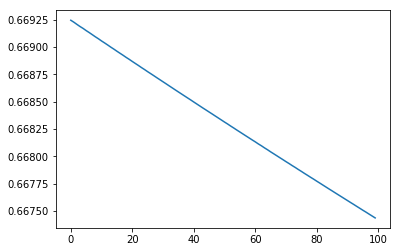

In [131]:
f, ax = plt.subplots()
ax.plot(ls)

# todo: 

[ ] model2: try softmax as activation  
[ ] add batchnorm layer to model1 and model2  
[ ] do  7-1

## 1. Compare activation functions 

In [42]:
# Wrong way to set initial weights 
# because no inplace functions are allowed for Variables with'requires_grad=True'
# Ref: https://discuss.pytorch.org/t/how-to-initiate-parameters-of-layers/1460
def wrong_weight_init(m):
    if isinstance(m, nn.Linear):
        torch.manual_seed(RSEED)
        m.weight.normal_() # error! 
        m.bias.normal_() # error!
        
def weight_init(m):
    if isinstance(m, nn.Linear):
        torch.manual_seed(RSEED)
        m.weight.data.normal_() 
        m.bias.data.normal_() 
            #alternatively set initial bias to zero
            # m.bias.data.fill_(0)
        

Sigmoid
initial weights: 
error: (tensor(1.0115), tensor(0.9651))
ReLU
initial weights: 
error: (tensor(1.9250), tensor(0.8557))
Softplus
initial weights: 


/root/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([759])) that is different to the input size (torch.Size([759, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


error: (tensor(1.7451), tensor(0.7730))


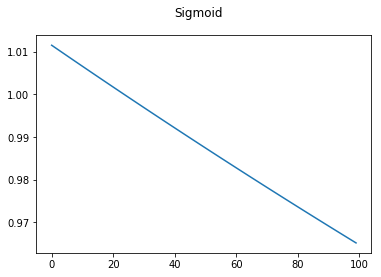

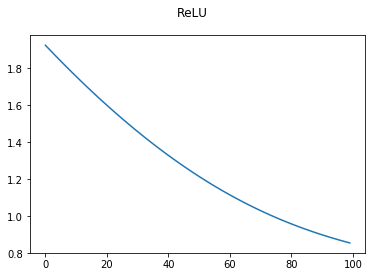

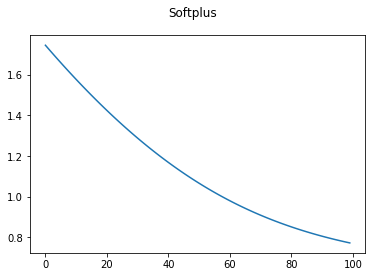

In [133]:
# BCEloss 
criterion = nn.BCELoss(size_average=True)

model_relu = BCModel(X.shape[1], H1, H2, nn.ReLU() )
acts = [nn.Sigmoid(), nn.ReLU(), nn.Softplus()]

for act in acts: 
    actname = act.__class__.__name__
    print(actname)
    model = BCModel(X.shape[1], H1, H2, activation=act)
    model.apply(weight_init)
    print("initial weights: ")
#     model.print_params()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # Train
    ls = []
    for epoch in range(100):
        #forward
        y_pred = model(X)
        
        #loss
        l = criterion(y_pred, y)
        ls.append(l)
        #zero-out grads
        optimizer.zero_grad()
        
        #backward pass
        l.backward()
        
        #update parameters
        optimizer.step()
    f,ax = plt.subplots()
    f.suptitle(actname)
    ax.plot(ls)
    print(f"error: {ls[0], ls[-1]}")

Side: setting a random seed for pytorch
- Must set the seed before calling a random number generating function.

In [134]:
torch.manual_seed(2)
print(torch.rand(2))

torch.manual_seed(2)
print(torch.rand(2)) # gives the same random numbers

tensor([ 0.6147,  0.3810])
tensor([ 0.6147,  0.3810])


In [135]:
# However, thess will not.

torch.manual_seed(2)
print(torch.rand(2))

print(torch.rand(2))

tensor([ 0.6147,  0.3810])
tensor([ 0.6371,  0.4745])


In [136]:
# Set the seed manually right before calling the random generator 
for i in range(3):
    torch.manual_seed(2)
    print(torch.rand(2))
    

tensor([ 0.6147,  0.3810])
tensor([ 0.6147,  0.3810])
tensor([ 0.6147,  0.3810])


- Example: nn Linear module's weight initialization from a normal distribution with a random seed

In [137]:
print("original: \n", model.l1.weight.data)
print("normal call: \n", model.l1.weight.data.normal_())
print("normal call: \n", model.l1.weight.data.normal_())

original: 
 tensor([[-0.5209,  1.0293, -0.3506,  0.1164, -0.1888, -1.4995,  0.1282,
         -0.5361],
        [ 0.0801, -0.1853,  0.7937,  0.9629,  0.7823,  0.4834, -1.8192,
         -0.5442],
        [ 1.9123,  0.2977, -0.7049,  0.4994, -0.0474,  1.3253,  0.9269,
          0.2274]])
normal call: 
 tensor([[-1.3042, -1.1097, -1.2188,  1.1676, -1.0574, -0.1188, -0.3298,
          0.0958],
        [-1.1233, -0.0919, -0.1320, -0.2751, -0.2350,  0.0937, -0.7650,
          1.8299],
        [-0.1752,  0.6990, -0.6861,  0.7202,  0.1963,  0.6142,  1.1566,
          0.4296]])
normal call: 
 tensor([[ 0.1665,  0.7911,  0.8560,  0.4094, -1.1371, -1.2034, -1.0190,
          0.3157],
        [-1.4702, -0.2134, -0.8707,  1.6159, -0.2356,  0.9444,  0.5461,
         -1.3575],
        [ 0.1757, -0.1319, -0.2735,  0.3355,  0.1885,  2.1432, -0.2779,
          0.5511]])


In [138]:
print("original: \n", model.l1.weight.data)
torch.manual_seed(RSEED)
print("normal call: \n", model.l1.weight.data.normal_())
torch.manual_seed(RSEED)
print("normal call: \n", model.l1.weight.data.normal_())

original: 
 tensor([[ 0.1665,  0.7911,  0.8560,  0.4094, -1.1371, -1.2034, -1.0190,
          0.3157],
        [-1.4702, -0.2134, -0.8707,  1.6159, -0.2356,  0.9444,  0.5461,
         -1.3575],
        [ 0.1757, -0.1319, -0.2735,  0.3355,  0.1885,  2.1432, -0.2779,
          0.5511]])
normal call: 
 tensor([[-0.5108,  1.0283, -0.3532,  0.1230, -0.1816, -1.4972,  0.1421,
         -0.5243],
        [ 0.0744, -0.1843,  0.7960,  0.9592,  0.7783,  0.4826, -1.8291,
         -0.5514],
        [ 1.9113,  0.2979, -0.7041,  0.4983, -0.0488,  1.3252,  0.9240,
          0.2255]])
normal call: 
 tensor([[-0.5108,  1.0283, -0.3532,  0.1230, -0.1816, -1.4972,  0.1421,
         -0.5243],
        [ 0.0744, -0.1843,  0.7960,  0.9592,  0.7783,  0.4826, -1.8291,
         -0.5514],
        [ 1.9113,  0.2979, -0.7041,  0.4983, -0.0488,  1.3252,  0.9240,
          0.2255]])


End of side

## 2. Classifying with minibatch

In [ ]:
N,D =  train_dataset.len, train_dataset.data.shape[1]
model = BCModel(D, H1, H2, activation=act)
model.apply(weight_init)
print("initial weights: ")
# model.print_params()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train
train_ls = []
dev_ls = []
for epoch in range(5000):
    for i, (x_batch, y_batch) in enumerate(train_loader):
        #forward
        y_pred = model(x_batch)

        #loss
        l = criterion(y_pred, y_batch)
        train_ls.append(l)
        #zero-out grads
        optimizer.zero_grad()

        #backward pass
        l.backward()

        #update parameters
        optimizer.step()
        
#     if (epoch%49 == 0):
# #         dev_l = criterion(dev_ypred, dev_y)
#         dev_ls.append(dev_l)
#         print(f"Epoch {epoch}: {train_ls[-1], dev_ls[-1]}")
        
        
f,ax = plt.subplots()
ax.plot(ls)
print(f"error: {ls[0], ls[-1]}")

initial weights: 


/root/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/root/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


In [584]:
#Test loop
# test loss
test_ls = []
isCorrects = []
with torch.no_grad():
    for i, (xtest_batch, ytest_batch) in enumerate(test_loader):
#         print(i)
        ypred_batch = model(xtest_batch).view(ytest_batch.size())
        test_l = criterion(ypred_batch, ytest_batch).item()

        # make a decision at 0.5
        decision_batch = (ypred_batch > 0.5).type(ytest_batch.dtype)
#         pdb.set_trace()
        # collect isCorrects
        isCorrect_batch = (decision_batch==ytest_batch).numpy()
        acc_batch = sum(isCorrect_batch)/len(isCorrect_batch)
        print('test acc: ', acc_batch)
#         pdb.set_trace()
#         isCorrects.extend(isCorrect_batch)


0
test acc:  0.44047619047619047


Avg test batch loss: 0.6349934861063957
Test accuracy:  0.6733067729083665


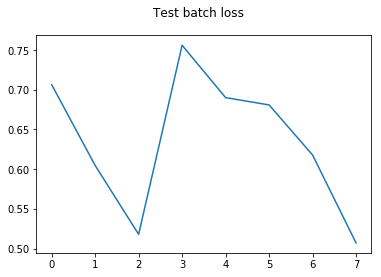

In [141]:
#Test loop
# test loss
test_ls = []
isCorrects = []
with torch.no_grad():
    for i, (xtest_batch, ytest_batch) in enumerate(test_loader):
        ypred_batch = model(xtest_batch).view(ytest_batch.size())
        test_ls.append(criterion(ypred_batch, ytest_batch).item())

        # make a decision at 0.5
        decision_batch = (ypred_batch > 0.5).type(ytest_batch.dtype)
#         pdb.set_trace()
        # collect isCorrects
        isCorrect_batch = (decision_batch==ytest_batch).numpy()
#         pdb.set_trace()
        isCorrects.extend(isCorrect_batch)
        
f,ax = plt.subplots()
f.suptitle('Test batch loss')
ax.plot(test_ls)
print('Avg test batch loss:', np.mean(test_ls))
print('Test accuracy: ', sum(isCorrects)/len(isCorrects))
    

Let's take a look at misclassified examples.

### side: batch norm layer

In [540]:
bn = nn.BatchNorm1d()

TypeError: __init__() missing 1 required positional argument: 'num_features'

### side: transform
*Note*: the loaded data is already normalized. See where the LunaDataset is defined.

Define transform objects to apply for data samples as a class so that we don't need to specify the settings (ie. parameters to the transform object) everytime the transformation is applied to samples.   
Key: `__call__(self, sample)` function 

In [434]:
class Rescale(object):
    """Rescale the image in a sample to a given size
    Args:
        output_size (int or tuple): Desired output size. If tuple, output is matched to 
        output size. If int, smaller of image dimensions is matcehd to output_size keeping
        ratio the same as the original image.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
#         if isinstance(output_size, tuple):
#             self.

    def __call__(self, sample):
        """
        input: a data point (sample) from the dataset
        output: transformed sample 
        """
        pass
#         return transformed

## 3. Try a deeper network

Simple batch norm layer 

In [26]:
# bn = nn.BatchNorm1d()
N,D =  train_dataset.len, train_dataset.data.shape[1]
criterion = nn.BCELoss(size_average=True)


In [30]:
class DeepBCModel(nn.Module):
    def __init__(self, dims, 
                 hidden_activation=nn.ReLU(), 
                 output_activation=nn.Sigmoid()):
        """
        dims: a list of dimensions of layer. [inDims, H1, H2,...].
        It doesn't includ the output layer's size, which is fixed to 1"""
        super(DeepBCModel,self).__init__()
        
        self.__build_layers__(dims)
        self.n_layers = len(dims)
        self.n_batch_norms = self.n_layers - 1 # Q:don't need for the last layer(right before softmax)
        
#         self.batch_norm = nn.BatchNorm1d() #todo
        self.h_activation = hidden_activation
        self.o_activation = output_activation
        
    def __build_layers__(self, dims):
#         assert(len(self.layers) == 0)
#         for i in range(len(dims)-1):
#             self.add_module(f'h{i}', self.h_activation(nn.Linear(dims[i],dim[i+1])))
#         self.add_module(f'h{len(dim)-1}', self.o_activation(nn.Linear(dims[-1],1)))
                            
        for i in range(len(dims)-1):
            self.add_module(f'li{i}', (nn.Linear(dims[i],dims[i+1])))
        self.add_module(f'li{len(dims)-1}', nn.Linear(dims[-1],1))
        
    def forward(self, x):
        y_pred = x
        
        for (mname, m) in self.named_children():
            if not isinstance(m, nn.Linear):
#                 print(mname, ': pass')
                continue
                
            if (str(self.n_layers-1) in mname):
#                 print(mname, ': last layer')
                act = self.o_activation
            else:
#                 print(mname, ": middle layer" )
                act = self.h_activation
                
            y_pred = act(m(y_pred))
        return y_pred
    

In [65]:
def get_train_loss(model, criterion, train_dataset, exclude_indices):
    """
    Compute loss on training dataset except data indexed at
    exclude_indices.
    Args:
    - model: trained model with forward function
    - criterion: loss function that takes in (ypred, y)
    - train_dataset (Dataset): training dataset 
    - exclude_indices: indices to exclude from train_dataset 
        when computing the loss, eg: batch indices used to 
        fit the current model
    """
    n = len(train_dataset)
    if isinstance(exclude_indices, torch.Tensor):
        exclude_indices = exclude_indices.numpy()
    include_indices = [i for i in range(n) if i not in exclude_indices]
    samples = train_dataset[include_indices]
    x = samples[0]
    y = samples[1]
#     pdb.set_trace()
#     x_tensor = torch.tensor(x)
#     y_tensor = torch.stack(y)
#     pdb.set_trace()
    with torch.no_grad():
        ypred = model(x).type_as(y)
        loss = criterion(ypred, y).item()
    return loss  

- Test get_train_loss


In [66]:
excludes = range(32)
get_train_loss(model, criterion, train_dataset, excludes)

/root/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([137])) that is different to the input size (torch.Size([137, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


12.30285930633545

- Test DeepBCModel constructor

In [59]:
N,D =  train_dataset.len, train_dataset.data.shape[1]

dims = [D, 200,200,200]
M = DeepBCModel(dims)
criterion = nn.BCELoss(size_average=True)

print(M)
print(M.n_layers)

DeepBCModel(
  (li0): Linear(in_features=96, out_features=200, bias=True)
  (li1): Linear(in_features=200, out_features=200, bias=True)
  (li2): Linear(in_features=200, out_features=200, bias=True)
  (li3): Linear(in_features=200, out_features=1, bias=True)
  (h_activation): ReLU()
  (o_activation): Sigmoid()
)
4


In [60]:
for m in M.children():
    print(m)

Linear(in_features=96, out_features=200, bias=True)
Linear(in_features=200, out_features=200, bias=True)
Linear(in_features=200, out_features=200, bias=True)
Linear(in_features=200, out_features=1, bias=True)
ReLU()
Sigmoid()


In [146]:
# check forward function
dataiter = iter(train_loader)
x1, y1 = dataiter.next()

In [147]:
M(x1);

### Experiments

In [67]:
# Hyperparameters
learning_rate = 0.0001
nEpoch = 1000
H1 = 200; H2 = 200; H3 = 100; H4 = 100
dims = [D, H1, H2, H3, H4]

In [68]:
model = DeepBCModel(dims)
model.apply(weight_init)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [72]:
# Train
debug = False
train_ls = []
train_ls_v2 = []

train_accs = []
for epoch in range(nEpoch):
#     print("="*30)
#     print(f'epoch {epoch}')
    train_isCorrects = [] 
    for i, (x_batch, y_batch, i_batch) in enumerate(train_loader):
        if debug:
            print(x_batch.size())
            print(y_batch.size())
            print(i_batch.size())
            pdb.set_trace()

        #forward
        ypred_batch = model(x_batch).view(y_batch.size())
        
        #loss
        l = criterion(ypred_batch, y_batch)
        train_ls.append(l.item())
        #zero-out grads
        optimizer.zero_grad()

        #backward pass
        l.backward()

        #update parameters
        optimizer.step()
        
        if debug:
            print(ypred_batch.size(), ypred_batch.dtype)
            print(y_batch.size(), y_batch.dtype)
            print(i_batch)
            pdb.set_trace()
            
        # Compute training loss and accuracy
        
        l_v2 = get_train_loss(model, criterion, train_dataset, i_batch)
        train_ls_v2.append(l_v2)
        # make a decision at 0.5
        # boolean tensor is uint8 type. Cast it to tensor.float32
        decision_batch = (ypred_batch > 0.5).view(y_batch.size()).type(y_batch.dtype)
        # collect isCorrects
        isCorrect_batch = (decision_batch==y_batch).numpy()
#         print(decision_batch.size(),  isCorrect_batch.shape)
#         pdb.set_trace()
        batch_acc = sum(isCorrect_batch)/len(isCorrect_batch)
        train_accs.append(batch_acc)
#         print(f'\t batch{i} acc: {batch_acc}')

    # Dev accuracy
#     if (epoch%49 == 0):
#         dev_l = criterion(dev_ypred, dev_y)
#         dev_ls.append(dev_l)
#         print(f"Epoch {epoch}: {train_ls[-1], dev_ls[-1]}")
#     print(f'epoch{epoch} acc: {sum(train_accs)/len(train_accs)}')

/root/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([137])) that is different to the input size (torch.Size([137, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/root/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([160])) that is different to the input size (torch.Size([160, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


In [151]:
f,axes = plt.subplots(3,1)
axes[0].plot(train_ls)
axes[1].plot(train_accs)
axes[2].plot(dev_ls) #Devset error
print(f"Train batch losses: {train_ls[0], train_ls[-1]}")
print(f"Train accuracy: {train_accs[0], train_accs[-1]}")

Devset error

Train batch losses: (7.771225452423096, 4.605170249938965)
Train accuracy: (0.71875, 0.8333333333333334)


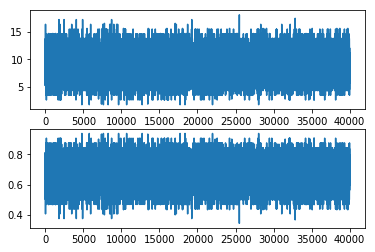

In [151]:
print(f"Dev  losses: {dev_ls[0], dev_ls[-1]}")

Avg test batch loss: 9.206343412399292
Test accuracy:  0.6733067729083665


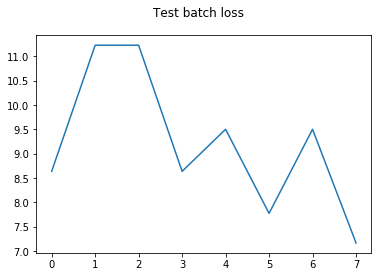

In [152]:
#Test loop
# test loss
test_ls = []
test_isCorrects = []
with torch.no_grad():
    for i, (xtest_batch, ytest_batch) in enumerate(test_loader):
        ypred_batch = model(xtest_batch).view(ytest_batch.size())
        test_ls.append(criterion(ypred_batch, ytest_batch).item())

        # make a decision at 0.5
        decision_batch = (ypred_batch > 0.5).type(ytest_batch.dtype)
#         pdb.set_trace()
        # collect isCorrects
        isCorrect_batch = (decision_batch==ytest_batch).numpy()
#         pdb.set_trace()
        test_isCorrects.extend(isCorrect_batch)
        
f,ax = plt.subplots()
f.suptitle('Test batch loss')
ax.plot(test_ls)
print('Avg test batch loss:', np.mean(test_ls))
print('Test accuracy: ', sum(isCorrects)/len(isCorrects))
    